In [1]:
PROJECT_PATH = '/content/drive/MyDrive/Colab Notebooks/Workspace/'

import sys
sys.path.insert(1, PROJECT_PATH + "Local-Approximation-Models-develop")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from os import walk
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
import itertools

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tqdm

import utils
import math

In [2]:
class DataFile():
  def __init__(self, filename, interval = 0.005, weight = None, height = None, age = None, visual = False):
    self.filename = filename
    self.weight = weight
    self.height = height
    self.path_data = "/content/drive/MyDrive/Colab Notebooks/Диплом/data/"
    data = pd.read_csv(self.path_data + self.filename, sep = ';', thousands='.', decimal=',') 
    data = data.groupby(['time'], as_index = False).mean()
    t = data.values[:, 0]
    t_new = np.arange(np.min(t), np.max(t), interval)
    x_new = interp1d(t, data.values[:, 1], kind='cubic')(t_new)
    y_new = interp1d(t, data.values[:, 2], kind='cubic')(t_new)
    z_new = interp1d(t, data.values[:, 3], kind='cubic')(t_new)
    self.data = pd.DataFrame(data = {'t': t_new, 'x': x_new, 'y': y_new, 'z': z_new})
    if visual:
      self.data.iloc[:6000, 1:].plot(figsize = (28,10))
      self.data.iloc[-6000:-1, 1:].plot(figsize = (28,10))
    self.data['weight'] = weight
    self.data['height'] = height
    self.data['age'] = age

  def trim(self):
    self.data = self.data.iloc[self.START:self.END, :]
    self.data.to_csv(self.filename, index=False)

  def get_data(self):
    return self.data

class DataFile():
  def __init__(self, filename, interval = 0.005, weight = None, height = None, age = None, visual = False):
    self.filename = filename
    self.weight = weight
    self.height = height
    self.path_data = "/content/drive/MyDrive/Colab Notebooks/Диплом/data/"
    data = pd.read_csv(self.path_data + self.filename, sep = ';', thousands='.', decimal=',') 
    self.data = pd.DataFrame(data = data.values[:, 1:4], columns = ['x', 'y', 'z'])
    if visual:
      self.data.iloc[:6000, 1:].plot(figsize = (28,10))
      self.data.iloc[-6000:-1, 1:].plot(figsize = (28,10))
    self.data['weight'] = weight
    self.data['height'] = height
    self.data['age'] = age

  def trim(self):
    self.data = self.data.iloc[self.START:self.END, :]
    self.data.to_csv(self.filename, index=False)

  def get_data(self):
    return self.data

def sphereFit(spX,spY,spZ):
    '''
    spX, spY, spZ: np.array([lenght])
    
    return:
    the radius and coordinates of the center of the ball, which was constructed from points by the method of least squares
    '''
    #   Assemble the A matrix
    spX = np.array(spX)
    spY = np.array(spY)
    spZ = np.array(spZ)
    A = np.zeros((len(spX),4))
    A[:,0] = spX*2
    A[:,1] = spY*2
    A[:,2] = spZ*2
    A[:,3] = 1

    #   Assemble the f matrix
    f = np.zeros((len(spX),1))
    f[:,0] = (spX*spX) + (spY*spY) + (spZ*spZ)
    C, residules, rank, singval = np.linalg.lstsq(A,f)

    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = math.sqrt(t)

    return radius, C[0], C[1], C[2]
    
def plot3d(trajectory, ind, sphere = False, projection = False):
  '''
  trajectory: np.array([lenght, N])
  ind: np.array(3) indexes of the 3 columns in which the rows to build are located
  sphere = True if you need to build a sphere by approximating the points with least squares
  projection = True if you need to project points on a sphere
  '''
  x = trajectory[:, ind[0]]
  y = trajectory[:, ind[1]]
  z = trajectory[:, ind[2]]
  if projection == True:
    s = np.sqrt(x**2 + y**2 + z**2)
    x = x/s
    y = y/s
    z = z/s

  fig = go.Figure(data=go.Scatter3d(
      x=x, y=y, z=z,
      marker=dict(
          size=3,
          color='red',
      ),
      line=dict(
          color='red',
          width=1.5
      )
  ))

  if sphere == True:
    if projection == True:
      u = np.linspace(0, 2 * np.pi, 100)
      v = np.linspace(0, np.pi, 100)
      x1 = 0.99 * np.outer(np.cos(u), np.sin(v))
      y1 = 0.99 * np.outer(np.sin(u), np.sin(v))
      z1 = 0.99 * np.outer(np.ones(np.size(u)), np.cos(v))
      x0 = y0 = z0 = 0
    else:
      r, x0, y0, z0 = sphereFit(x, y, z)
      u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
      x1=np.cos(u)*np.sin(v)*r
      y1=np.sin(u)*np.sin(v)*r
      z1=np.cos(v)*r
      x1 = x1 + x0
      y1 = y1 + y0
      z1 = z1 + z0
    fig.add_trace(go.Surface(x=x1, y=y1, z=z1, opacity = 0.4, surfacecolor = (x1-x0)**2+(y1-y0)**2+(z1-z0)**2 ))
  fig.show()

def comparison_plot3d(ind, trajectory1, trajectory2, trajectory3 = None):
  '''
  trajectory: np.array([lenght, N]) trajectories to be plotted in a single drawing
  ind: np.array(3) indexes of the 3 columns in which the rows to build are located
  
  '''
  x1 = trajectory1[:, ind[0]]
  y1 = trajectory1[:, ind[1]]
  z1 = trajectory1[:, ind[2]]
  x2 = trajectory2[:, ind[0]]
  y2 = trajectory2[:, ind[1]]
  z2 = trajectory2[:, ind[2]]
  fig = go.Figure(data=go.Scatter3d(
      x=x1, y=y1, z=z1,
      marker=dict(
          size=3,
          color='blue',
      ),
      line=dict(
          color='blue',
          width=1.5
      )
  ))
  fig.add_trace(go.Scatter3d(
      x=x2, y=y2, z=z2,
      marker=dict(
          size=3,
          color='red',
      ),
      line=dict(
          color='red',
          width=1.5
      )
  ))
  if trajectory3 is not None:
    x3 = trajectory3[:, ind[0]]
    y3 = trajectory3[:, ind[1]]
    z3 = trajectory3[:, ind[2]]
    fig.add_trace(go.Scatter3d(
      x=x3, y=y3, z=z3,
      marker=dict(
          size=3,
          color='green',
      ),
      line=dict(
          color='green',
          width=1.5
      )
    ))
  fig.show()

def to_phase_trajectory_multi(data, l):
  '''
  calculates its phase path for each column
  data: np.array([lenght, N]) time series
  l: int dimension of the space of phase trajectories
  return np.array([N, lenght, l])
  '''
  phases = np.zeros(data.shape[1], data.shape[0], l)
  for i, x in enumerate(data.T):
    phases[i] = to_phase_trajectory(x, l)
  return phases

def get_spectrum(series, l, n_comp = 2):
  '''
  projects phase trajectory of time series into a space of dimension n_comp
  series: np.array([lenght]) time series
  l: int dimension of the space of phase trajectories
  n_comp: int dimension projection phase trajectory
  return np.array([lenght, n_comp])
  '''
  phase = to_phase_trajectory(series, l)

  model = PCA(n_components = n_comp)
  projection = model.fit_transform(phase)
  basis = model.components_
  print('Explained variation'
        ' for {} principal components: {}'.format(n_comp,
                                                  model.explained_variance_ratio_))
  print('Cumulative explained variation'
        'for {} principal components: {}\n'.format(n_comp,
                                                  np.sum(model.explained_variance_ratio_)))
  return projection

def get_spectrum_multi(data, l, n_comp = 2):
  '''
  projects concat phase trajectories of time series into a space of dimension n_comp
  data: np.array([lenght, N]) time series
  l: int dimension of the space of phase trajectories
  n_comp: int dimension projection phase trajectory
  return np.array([lenght, n_comp])
  '''
  spectrums = np.zeros([data.shape[0] - l, data.shape[1]*n_comp])
  for i, x in enumerate(data.T):
    spectrums[:, n_comp*i : n_comp*i+n_comp] = get_spectrum(x, l, n_comp = n_comp)
  model = PCA(n_components = n_comp)
  spectrums = model.fit_transform(spectrums)
  return spectrums

def plot2d(x, y):
  plt.figure(figsize=(6, 6))
  plt.plot(x, y)
  plt.show()

In [3]:
data_dict = {}
name_list = []
for (dirpath, dirnames, filenames) in walk("/content/drive/MyDrive/Colab Notebooks/Диплом/data/"):
    name_list.extend(filenames)
    break

interval = 0.005
T = 3
discrete = 0.5
N_comp = 2

for filename in name_list:
  data_one = DataFile(filename, interval = interval, weight = 189, height = 84, age = 20)
  data_one.START = 4000
  data_one.END = 50000
  data_one.trim()
  data_dict[filename] = data_one

In [4]:
data = data_dict['S_run.csv'].get_data().iloc[10000:30000,:]
data['A'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
x = data['x'].values
y = data['y'].values
z = data['z'].values
A = data['A'].values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
x.shape

(20000,)

In [6]:
l = 300

train_X = x[0:7000]
test_X = x[7000:10000]

trajectory = utils.to_phase_trajectory(train_X, l)
train_H = np.zeros([trajectory.shape[0]-l, trajectory.shape[1]])
train_T = trajectory[l:,:]
for i in tqdm.tqdm(range(0, trajectory.shape[0]-l)):
  X = trajectory[i:i+2*l, :]
  train_H[i] = np.linalg.svd(X , full_matrices = True, compute_uv = False)

pd.DataFrame(train_H).to_csv('train_H.csv', index=False)

trajectory = utils.to_phase_trajectory(test_X, l)
test_H = np.zeros([trajectory.shape[0]-l, trajectory.shape[1]])
test_T = trajectory[l:,:]
for i in tqdm.tqdm(range(0, trajectory.shape[0]-l)):
  X = trajectory[i:i+2*l, :]
  test_H[i] = np.linalg.svd(X , full_matrices = True, compute_uv = False)

pd.DataFrame(test_H).to_csv('test_H.csv', index=False)

100%|██████████| 2400/2400 [00:59<00:00, 40.22it/s]


In [7]:
test_H = pd.read_csv('test_H.csv').to_numpy()
train_H = pd.read_csv('train_H.csv').to_numpy()
train_H.shape, train_T.shape, test_H.shape, test_T.shape

((6400, 300), (6400, 300), (2400, 300), (2400, 300))

In [15]:
from sklearn.neighbors import NearestNeighbors
knn_H = NearestNeighbors(n_neighbors=1)
knn_T = NearestNeighbors(n_neighbors=1)
knn_H.fit(train_H[:-l])
knn_T.fit(train_T[:-l])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                 radius=1.0)

In [16]:
def predict(knn, T, historys, l):
  nier_idx = np.array(knn.kneighbors(historys, return_distance=False))
  predict_idx = nier_idx + l
  predict = np.zeros(historys.shape)
  for i in range(historys.shape[0]):
    predict[i] = np.sum(T[predict_idx[i], :], axis = 0)
  return predict

def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))/len(A)

In [66]:
pred_T = predict(knn_T, train_T, test_T[:-l], l)
pred_H = predict(knn_H, train_T, test_H[:-l-30], l)
true_pred1 = test_T[l :, : ]
true_pred2 = test_T[l+30 :, : ]

In [56]:
true_pred1 = test_T[l :, : ]
true_pred2 = test_T[l : , : ]

In [67]:
print('base score:', smape(pred_T, true_pred1))
print('modification score:', smape(pred_H, true_pred2))

base score: 0.1442065624870118
modification score: 0.1991631597238214


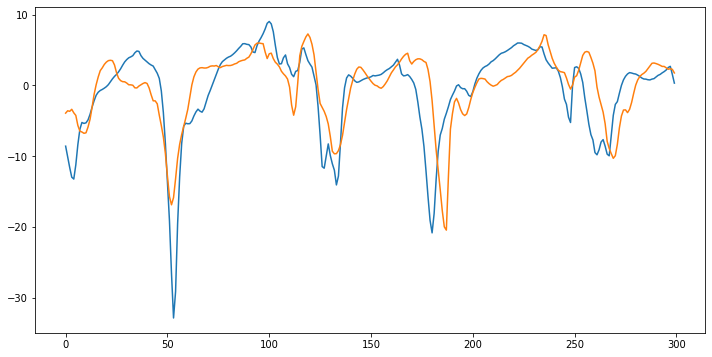

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(pred_T[100])
plt.plot(true_pred1[100])
plt.show()

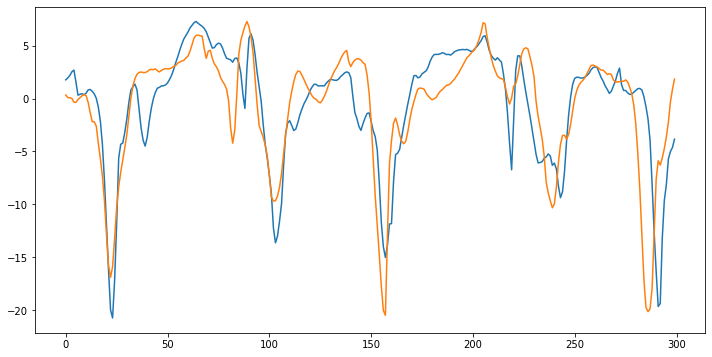

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(pred_H[100])
plt.plot(true_pred2[100])
plt.show()